# Training a Unet model for segmentation

Importing useful packages

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import ipdb

Useful paths

In [2]:
TILE_PATH = './dataset/tiles/images/'
TILE_GT_PATH = './dataset/tiles/ground_truth/'
LABELS_FILE = './dataset/tiles/labels.csv'

### Loading the data

First we create a Dataset object and a transform function that converts a data point to a tensor. We load the tile dataset and then we split it randomly as follows: 

* 10% N1 train - pixel-level labels;
* 70% N2 train - class labels;
* 20% validation - validation set.

In [3]:
class VaihingenDataset(Dataset):

    def __init__(self, img_dir, gt_dir, transform=None):

        self.img_dir = img_dir
        self.gt_dir = gt_dir

        self.data_points = os.listdir(self.img_dir)

        self.transform = transform

    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):

        img_name = os.path.join(self.img_dir,
                                self.data_points[idx])
        gt_name = os.path.join(self.gt_dir, self.data_points[idx])

        img = io.imread(img_name) 
        gt = io.imread(gt_name)
        
        # normalizing the data
        img_float = img / 255.
        gt_float = gt / 255.

        sample = (img_float.astype(np.float32), gt_float.astype(np.float32))

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):

    def __call__(self, sample):
        img, gt = sample[0], sample[1]

        # swapping axes
        img = img.transpose((2, 0, 1))
        gt = gt.transpose((2, 0, 1))
        return (torch.from_numpy(img), torch.from_numpy(gt))

In [6]:
ds = VaihingenDataset(TILE_PATH, TILE_GT_PATH, transform=ToTensor())

In [7]:
n1_len = int(0.1 * len(ds))
n2_len = int(0.7 * len(ds))
n_valid_len = len(ds) - n1_len - n2_len

print('N1 train size: {}/{}.'.format(n1_len, len(ds)))
print('N2 train size: {}/{}.'.format(n2_len, len(ds)))
print('Validation size: {}/{}.'.format(n_valid_len, len(ds)))

n1_train, n2_train, n_valid = random_split(ds, [n1_len, n2_len, n_valid_len])

N1 train size: 1463/14636.
N2 train size: 10245/14636.
Validation size: 2928/14636.


We define a data loader for each subset

In [8]:
BATCH_SIZE = 16

n1_dataloader = DataLoader(n1_train, batch_size=BATCH_SIZE)
n2_dataloader = DataLoader(n2_train, batch_size=BATCH_SIZE)
n_valid_dataloader = DataLoader(n_valid, batch_size=BATCH_SIZE)

### Implementing the model

We are using a Unet model; the architecture is part of the tutorial that can be found [here](https://www.youtube.com/watch?v=IHq1t7NxS8k).

In [62]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=3, features=[32, 64, 128],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        x = self.final_conv(x)

        return self.sigmoid(x)

In [63]:
model = UNET(out_channels=3)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

if torch.cuda.is_available():
    model.cuda()

Using cuda device


In [65]:
def train(dataloader, model, loss_fn, optimizer):
  
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [66]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [67]:
torch.cuda.empty_cache()

epochs = 6
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(n1_dataloader, model, loss_fn, optimizer)
    test(n_valid_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.251165  [    0/ 1463]
loss: 0.128273  [  320/ 1463]
loss: 0.128287  [  640/ 1463]
loss: 0.103834  [  960/ 1463]
loss: 0.111390  [ 1280/ 1463]
Test avg loss: 0.109402 

Epoch 2
-------------------------------
loss: 0.097291  [    0/ 1463]
loss: 0.091014  [  320/ 1463]
loss: 0.100177  [  640/ 1463]
loss: 0.100669  [  960/ 1463]
loss: 0.086559  [ 1280/ 1463]
Test avg loss: 0.086619 

Epoch 3
-------------------------------
loss: 0.067389  [    0/ 1463]
loss: 0.085164  [  320/ 1463]
loss: 0.090507  [  640/ 1463]
loss: 0.083714  [  960/ 1463]
loss: 0.092342  [ 1280/ 1463]
Test avg loss: 0.085013 

Epoch 4
-------------------------------
loss: 0.070806  [    0/ 1463]
loss: 0.093049  [  320/ 1463]
loss: 0.092186  [  640/ 1463]
loss: 0.082743  [  960/ 1463]
loss: 0.069721  [ 1280/ 1463]
Test avg loss: 0.087375 

Epoch 5
-------------------------------
loss: 0.067369  [    0/ 1463]
loss: 0.090263  [  320/ 1463]
loss: 0.085316  [  640/ 1463]
loss: 

Saving the model

In [68]:
torch.save(model.state_dict(), "model_correct_long_sigmoid.pth")

Some example segmentations with the trained model

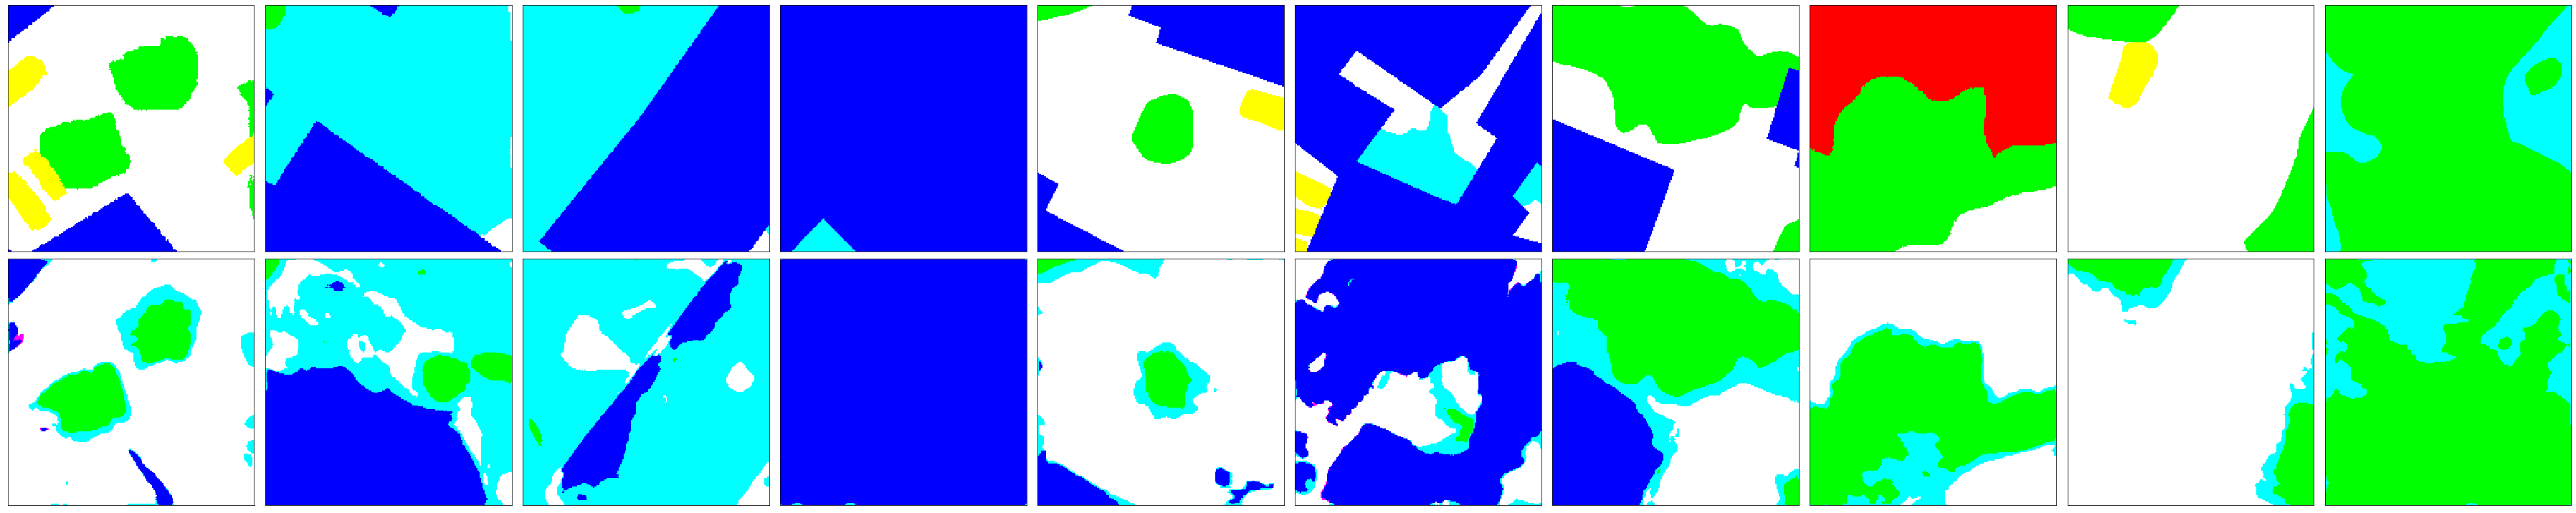

In [70]:
fig=plt.figure(figsize=(60,10))
columns = 12
rows = 2

num_examples = 10

i = 1
for idx in range(num_examples):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(torch.transpose(n_valid[idx][1], 0, 2))
    fig.add_subplot(rows, columns, columns + i)
    
    model.eval()
    with torch.no_grad():
        pred = model(torch.unsqueeze(n_valid[idx][0], dim=0).cuda())
        pred = (pred > 0.5).float()
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(torch.transpose(torch.squeeze(pred.cpu()), 0, 2), cmap='gray')
    i += 1
        
plt.xticks([])
plt.yticks([])
plt.tight_layout()